In [1]:
!pip install torch torchvision torchaudio scikit-learn medmnist

In [2]:
"""
Created on Mon Aug4 17:35:36 2025

@author: vigo
"""

import os
import sys
import argparse
import time
import pickle
from tqdm import trange
import numpy as np
import PIL
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11, vgg16, vgg19, resnet18, resnet50
import matplotlib.pyplot as plt
from scipy.io import savemat

#Related medmnist dataset
import medmnist
from medmnist import INFO, Evaluator

# Check for Cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


seed = 27
torch.manual_seed(seed)
random.seed(seed)

# Hyper-parameters 
n_epochs = 10
batch_size = 128
lr = 0.0001

#Network Hyper-parameters
hidden_size = 512

data_flag = 'organamnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])



#To work with 28x28 size images
#data_transform = transforms.Compose([
                 #transforms.ToTensor(),
                 #transforms.Normalize(mean=[.5], std=[.5])])

### To work with 224x224 resolution images
data_transform = transforms.Compose(
            [transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])]) 

# Image Size 28x28. Set RGB =True if the dataset contains colour images
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=False)
val_dataset = DataClass(split='val', transform=data_transform, download=True, as_rgb=False)
test_dataset = DataClass(split='test', transform=data_transform, download=True, as_rgb=False)


# Loaders that give 64 example batches
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True)


val_loader = data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=False)

test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False)

image, label = train_dataset[0]  # Get one sample image
print(f"Image shape: {image.shape}")


Image shape: torch.Size([1, 224, 224])


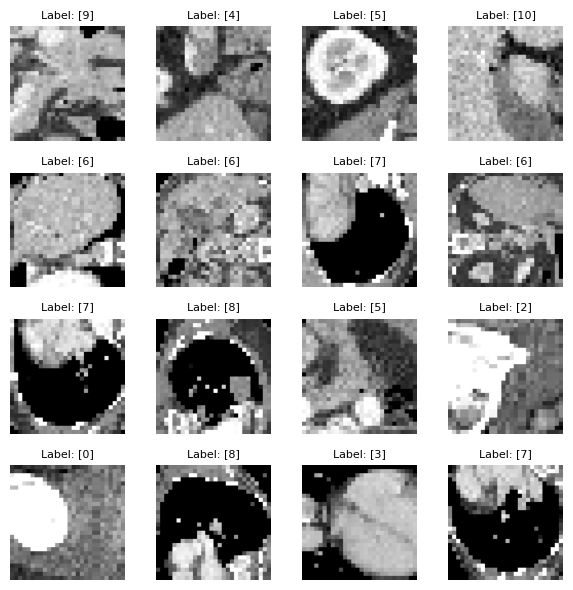

In [3]:
# select 16 random indices for plotting
indices = random.sample(range(len(train_dataset)), 16)

plt.figure(figsize=(6, 6))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    # If tensor, convert to 2D array (grayscale)
    if hasattr(image, 'squeeze'):
        image = image.squeeze()  # remove channel dimension if present

    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
#VGG models
conv_model = resnet50(pretrained = False)
# adapt first conv layer to match input chnanels (this is needed if you are feeding grayscale images)
old_conv = conv_model.conv1
conv_model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding
)

#Match the number of classes in the final fc layer
in_features = conv_model.fc.in_features
conv_model.fc = nn.Linear(in_features, n_classes)  


#Similarly Implement Transfer learning using Resent models.

conv_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()   #One can tray NLL loss
optimizer = torch.optim.Adam(conv_model.parameters(), lr=lr, betas=(0.9, 0.999))  #One can try AdamW optimizer

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# Training 
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    train_correct = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), torch.squeeze(targets, 1).long().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(outputs, 1)
        train_correct += (predictions == targets).sum().item()
        total_samples += targets.size(0)

    train_acc = (train_correct / total_samples) * 100
    return train_acc, loss.item()


# Validation/Test
def val(model, dataloader, criterion, device):
    model.eval()
    val_correct = 0
    total_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), torch.squeeze(targets, 1).long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs, 1)

            val_correct += (predictions == targets).sum().item()
            total_samples += targets.size(0)
            val_loss += loss.item()

    val_acc = (val_correct / total_samples) * 100
    avg_val_loss = val_loss / len(dataloader)
    return val_acc, avg_val_loss

Epoch--[1], Train_Accuracy: 77.92887937270334, Validation_Accuracy: 79.95686334925281
Epoch--[2], Train_Accuracy: 94.63846532218396, Validation_Accuracy: 93.89924510861192
Epoch--[3], Train_Accuracy: 97.33803998726889, Validation_Accuracy: 96.30257279309814
Epoch--[4], Train_Accuracy: 98.35652903561818, Validation_Accuracy: 96.225543059621
Epoch--[5], Train_Accuracy: 98.70952808078471, Validation_Accuracy: 97.58126636881836
Epoch--[6], Train_Accuracy: 99.36633777957815, Validation_Accuracy: 97.75073178246804
Epoch--[7], Train_Accuracy: 99.17537108301264, Validation_Accuracy: 97.41180095516869
Epoch--[8], Train_Accuracy: 99.3634443447817, Validation_Accuracy: 97.65829610229548
Epoch--[9], Train_Accuracy: 99.50232921501114, Validation_Accuracy: 96.88799876752427
Epoch--[10], Train_Accuracy: 99.48207517143601, Validation_Accuracy: 97.38098906177784


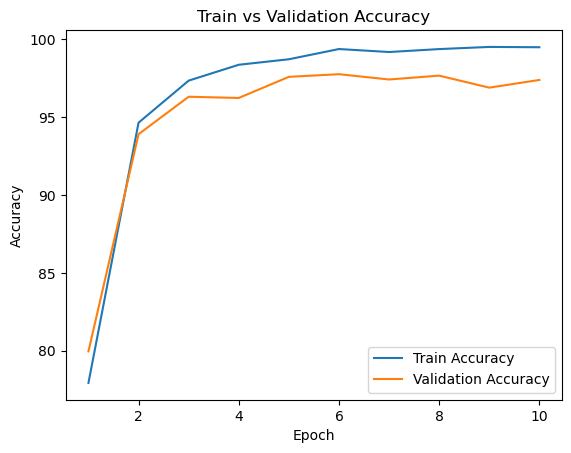

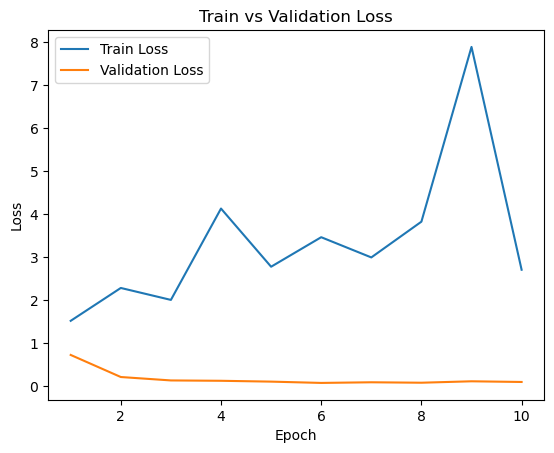

Test_Accuracy: 91.46135673304083


In [6]:
Train_Acc =[]
Train_Loss =[]

Val_Acc =[]
Val_Loss =[]

for epoch in range(n_epochs):
    train_acc, train_loss = train(conv_model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = val(conv_model, val_loader, criterion, device)
    print (f'Epoch--[{epoch+1}], Train_Accuracy: {train_acc}, Validation_Accuracy: {val_acc}')
    Train_Acc.append(train_acc)
    Train_Loss.append(train_loss)
    Val_Acc.append(val_acc)
    Val_Loss.append(val_loss)




# Plot Epoch vs Accuracy
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), Val_Acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
#plt.grid(True)
plt.show()

# Plot Epoch vs Loss
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), Val_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
#plt.grid(True)
plt.show()

#Testing
test_acc, test_loss = val(conv_model, test_loader, criterion, device)
print (f'Test_Accuracy: {test_acc}')